# **Could the self-description of early stage companies on their website serve as a predictive signal for VC to classify their future success?**
**Context**

VCs invest on startups strategically to earn money. To generate maximum return, it is important to invest on startups that are more likely to succeed. Given the unique challenges each startup faces, one could turn for data-driven insights for making investment choices.

We are provided with a data set from Vela Partners consisting of 5843 companies, 2156 are labelled as successful and 3687 are labelled as unsuccessful. In this notebook, we build a classification model using a deep learning approach by learning on the companies' self-description.

The model is inherently simple, it takes about 1 minute to train the model. Yet, it is able to give promising predictions. Through cross-validating into 5 folds, the models consistently return an average F1 score of 84%, recall of 82%, precision of 87% and accuracy of 90%.

# **Data Processing**

In [ ]:
pip install scikeras

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading successful(s for successful) startup dataset

In [4]:
s = pd.read_excel("/content/drive/My Drive/Vela Partners/Datasets/successful.xlsx", sheet_name = 'Long company descriptions')

Focus on long company description, showing the first 10 records of s

In [5]:
s.head(10)

,org_name,org_uuid,long_description
0,10X Banking,a2323b6c-29b9-4750-905c-cdcbd9ce92b8,"10x Banking (10x), a financial services techno..."
1,10X Genomics,cf3b00cf-ffbf-0e4f-6427-a60e5060de39,10x Genomics is creating revolutionary DNA seq...
2,"111, Inc.",0680987f-23cd-4fa5-850c-38326fffaa36,"111,Inc. is a leading digital and mobile healt..."
3,17zuoye,a79a6ae8-3c74-0db7-7e6b-b4f7662d37e8,17zuoye is an online learning platform for K-1...
4,1Komma5¬∞,1ca6a7b3-465b-443d-9028-388cfd1ad060,KOMMA5 ¬∞ offers all owners of electric vehicl...
5,1inch,8e5b2628-6d2b-4f0a-9808-07c935156515,1inch Limited builds decentralized protocols a...
6,360Learning,0995a94f-0661-0db6-fcae-cbb89937c945,360Learning develops a collaborative learning ...
7,3D Medicines,73588380-c823-48db-9139-31c17b38862b,"3D Medicines, we use individual‚Äôs genetic in..."
8,4D Molecular Therapeutics,310235fd-88ee-87dd-d394-b71762ba2431,4D Molecular Therapeutics is a biotechnology c...
9,4G Clinical,e94407ea-d3a5-0f75-f3d0-30ab8a43ac44,4G Clinical provides software and services for...


In [6]:
s[s.duplicated()]

,org_name,org_uuid,long_description


There are no duplicated entries in s.

In [7]:
s.isnull().values.any()

False

There are no missing values in s.

In [8]:
s.shape[0]

2156

There are 2156 successful entries

Loading unsuccessful(f for fail) startup dataset

In [9]:
f = pd.read_excel("/content/drive/My Drive/Vela Partners/Datasets/unsuccessful.xlsx", sheet_name = 'Long company descriptions')


The first 10 entries of failed startups long description

In [10]:
f.head(10)

,org_name,org_uuid,long_description
0,.Club Domains,477b73e7-f956-955d-06c0-2dc705a7e6de,.Club Domains is a domain extension for the so...
1,0glass,0ae0c059-31ac-4979-132f-352b31a6d448,0glass is the first high-tech company to apply...
2,100offer,0cebce5a-3efc-dd27-5ce6-a42245a79cf9,100offer is an opportunity marketplace for tal...
3,101 Edu,934bd25a-4b91-9d78-12c3-524c679d3e69,101 builds mobile-first teaching and assessmen...
4,17hats,c852c5d3-220d-2eb6-c78e-3c9148430ce4,17hats has become the small business owners ch...
5,1928 Diagnostics,e862bea8-d437-2370-6ccc-b117d5549e51,"1928 Diagnostics is a digital health company, ..."
6,1939 Games,87366b68-8997-b2e3-a601-bb37ee89a1fd,1939 Games is a indie game development studio ...
7,1DOC3,474524a8-5ffa-8ef9-a4c9-3effe64e21e0,1doc3 is a e-health platform that connects 490...
8,1Drop Diagnostics,df4774f0-cfd6-e0f7-abae-0394e7c658ef,1Drop Diagnostics is a cutting edge medical di...
9,1Huddle,51e4aae5-6ad5-e054-317b-7428bffd0870,"Today, companies struggle to onboard, upskill ..."


In [11]:
f[f.duplicated()]

,org_name,org_uuid,long_description


There are no duplicated entries in f.

In [12]:
f.isnull().values.any()

False

There are no missing values in f.

In [13]:
f.shape[0]

3687

There are 3687 unsuccessful entries

# **Removing stopwords**

These are common words in the language and they rarely provide useful information. The first word of the name of the startups are taken as stopwords as well since most of them are unique and carries not much information.

In [14]:
def remove_non_ascii(string):
    return ''.join(char for char in string if ord(char) < 128)

In [15]:
def remove_stopwords(sentence,df):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    # The first word of the name of the startups
    namelist = df.org_name.str.lower().values.tolist()
    for i in range(len(namelist)):
      namelist[i]=namelist[i].split(' ')[0]
    stopwords = stopwords + namelist
    # Sentence converted to lowercase-only
    sentence = sentence.lower()
    sentence = remove_non_ascii(sentence)
    newlist=sentence.split(' ')
    sentence=[]
    for j in newlist:
        for i in stopwords:
            if i==j:
                sentence.append(i)
    sentence = [item for item in newlist if item not in sentence]
    sentence=' '.join(sentence)
    return sentence

Creating a new column (newD) for the new description with stopwords removed, and a column for the successful/fail (1/0) label

In [16]:
s['newD']=s['long_description']
f['newD']=f['long_description']
s['label']=1
f['label']=0

In [17]:
for i in range(len(s)):
  s['newD'][i]=remove_stopwords(s.iloc[i,2],s)
for i in range(len(f)):
  f['newD'][i]=remove_stopwords(f.iloc[i,2],f)

In [18]:
s = s.drop(columns='long_description')
s = s.drop(columns='org_name')
s = s.drop(columns='org_uuid')
f = f.drop(columns='long_description')
f = f.drop(columns='org_name')
f = f.drop(columns='org_uuid')

shuffling the successful and failed startups long description with labels together

In [19]:
total = pd.concat([s,f])
total=total.sample(frac=1)
total.head()

,newD,label
811,worlds careers dedicated students graduates. t...,0
118,ai-driven research company focuses increasing ...,1
866,health technology company provides modular sup...,1
1357,tractor operator online intended facilitate co...,0
1921,brings industrial precision power consumer ass...,0


Calculating and plotting the number of words for each modified description

In [20]:
s['wordcount']=0
f['wordcount']=0
for i in range(len(s)):
  s['wordcount'][i]=len(s['newD'][i].split(' '))
for i in range(len(f)):
  f['wordcount'][i]=len(f['newD'][i].split(' '))

A visual scan tells us most startups have description fewer than 120 words, and thus set MAXLEN=120

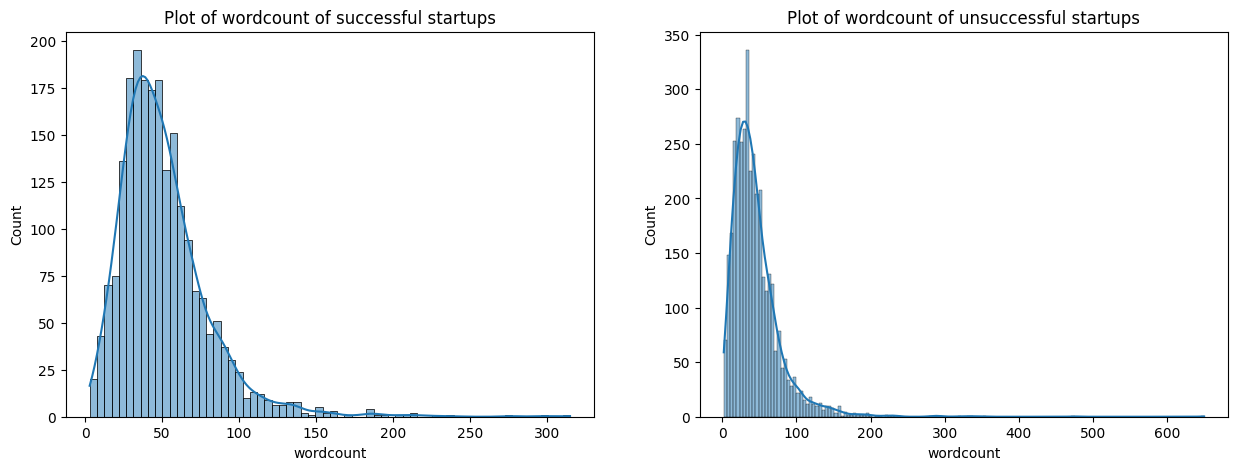

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(s['wordcount'], kde=True, ax=axes[0])
axes[0].set_title('Plot of wordcount of successful startups')

sns.histplot(f['wordcount'], kde=True, ax=axes[1])
axes[1].set_title('Plot of wordcount of unsuccessful startups')

plt.show()

## Defining useful global variables
[tf.keras.preprocessing.text.Tokenizer - reference link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

Define some global variables that will be used in the unit tests

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model.


- `MAXLEN`: Maximum length of all sequences.


- `PADDING`: Padding strategy (pad either before or after each sequence.).


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training.

In [22]:
NUM_WORDS = 10000
EMBEDDING_DIM = 8
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .7

## Training - Validation Split

Split the lists into training and validation sentences with a 0.7/0.3 split.

In [23]:
def train_val_split(sentences, labels, training_split):
  train_size = len(sentences)
  train_sentences = sentences[0:round(training_split*train_size)]
  train_labels = labels[0:round(training_split*train_size)]
  validation_sentences = sentences[round(training_split*train_size):]
  validation_labels = labels[round(training_split*train_size):]
  return train_sentences, validation_sentences, train_labels, validation_labels

In [24]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(total.newD, total.label, TRAINING_SPLIT)

## Tokenization - Sequences and padding

In [25]:
def fit_tokenizer(train_sentences, num_words, oov_token):
  # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, oov_token=oov_token)
  # Fit the tokenizer to the training sentences
  tokenizer.fit_on_texts(train_sentences)
  return tokenizer

In [26]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 20855 words

<OOV> token included in vocabulary


**Convert each text data point into its padded sequence representation.**

In [27]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
  # Convert sentences to sequences
  sequences = tokenizer.texts_to_sequences(sentences)
  # Pad the sequences using the correct padding and maxlen
  padded_sequences = tf.keras.utils.pad_sequences(sequences, maxlen=maxlen, padding=padding)
  return padded_sequences

In [29]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)
total_padded_seq = seq_and_pad(total.newD, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}\n")
print(f"Padded total sequences have shape: {total_padded_seq.shape}")

Padded training sequences have shape: (4090, 120)

Padded validation sequences have shape: (1753, 120)

Padded total sequences have shape: (5843, 120)


**Building the architecture of a neural network with three dense layers.**

In [30]:
def create_model(num_words, embedding_dim, maxlen):
  tf.random.set_seed(123)
  model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim,input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(163, activation='softmax'),
    tf.keras.layers.Dense(57, activation='sigmoid'),
    tf.keras.layers.Dense(17),
    tf.keras.layers.Dense(2, activation='softmax')])

  model.compile(loss="sparse_categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

In [31]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_padded_seq, train_labels, epochs=20, validation_data=(val_padded_seq, val_labels))

Epoch 1/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6593 - accuracy: 0.6386 - val_loss: 0.6764 - val_accuracy: 0.6132
Epoch 2/20
128/128 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6386 - val_loss: 0.6687 - val_accuracy: 0.6132
Epoch 3/20
128/128 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.6386 - val_loss: 0.6765 - val_accuracy: 0.6132
Epoch 4/20
128/128 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6386 - val_loss: 0.6851 - val_accuracy: 0.6132
Epoch 5/20
128/128 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6386 - val_loss: 0.6655 - val_accuracy: 0.6132
Epoch 6/20
128/128 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6386 - val_loss: 0.6566 - val_accuracy: 0.6132
Epoch 7/20
128/128 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6516 - val_loss: 0.6334 - val_accuracy: 0.6144
Epoch 

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 8)            80000     
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 163)               1467      
                                                                 
 dense_1 (Dense)             (None, 57)                9348      
                                                                 
 dense_2 (Dense)             (None, 17)                986       
                                                                 
 dense_3 (Dense)             (None, 2)                 36        
                                                        

55/55 [==============================] - 0s 909us/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1075
           1       0.89      0.80      0.84       678

    accuracy                           0.88      1753
   macro avg       0.89      0.87      0.88      1753
weighted avg       0.89      0.88      0.88      1753



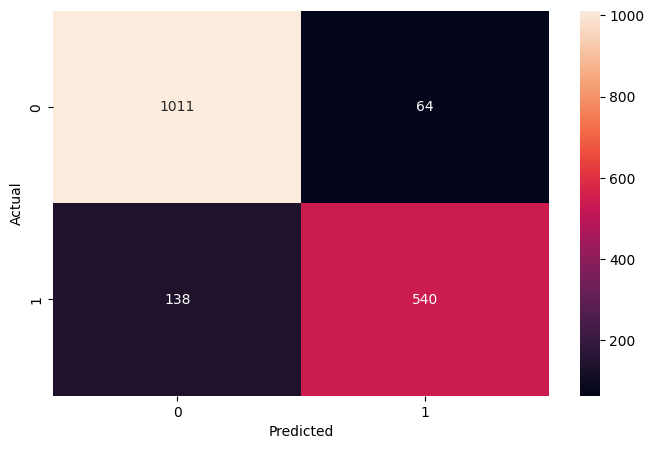

In [33]:
test_pred = model.predict(val_padded_seq)
test_pred = np.argmax(test_pred, axis=-1)

# Printing the classification report
print(classification_report(val_labels, test_pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(val_labels, test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

For this 0.7 training/validation split trial, the model returns an accuracy of 88%, a precision of 89% and a recall of 80%.

A zero rate classifier will classify all startups into 0, and thus a baseline accuracy of 62%.

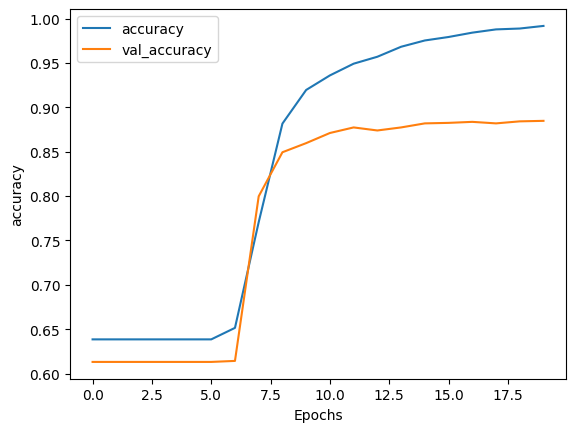

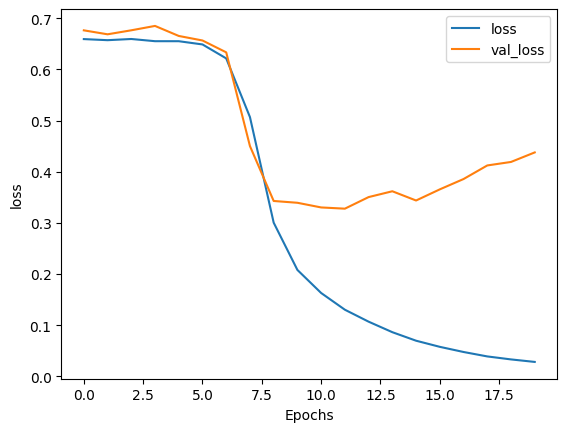

In [34]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The model is overfitting after about 8 epochs.

**Apart from training the model with a 0.7/0.3 split, we could use 5-fold cross validation to access the performance of this model. We compute the F1 score, recall, precision and accuracy.**

In [35]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=219)
estimator = KerasClassifier(build_fn=create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN), epochs=20, batch_size=32, verbose=0)

In [41]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
scoring = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score)
}

In [ ]:
scores = cross_validate(estimator, total_padded_seq, total['label'], cv=k_fold, scoring=scoring)

In [45]:
print("Cross-Validation Mean F1-score: {:.3f}".format(np.mean(scores['test_f1_score'])))
print("Cross-Validation Mean Precision: {:.3f}".format(np.mean(scores['test_precision'])))
print("Cross-Validation Mean Recall: {:.3f}".format(np.mean(scores['test_recall'])))
print("Cross-Validation Mean Accuracy: {:.3f}".format(np.mean(scores['test_accuracy'])))

Cross-Validation Mean F1-score: 0.845
Cross-Validation Mean Precision: 0.883
Cross-Validation Mean Recall: 0.812
Cross-Validation Mean Accuracy: 0.890


**Baseline model where the outcome is either 1 or 0 randomly for comparison**

              precision    recall  f1-score   support

           0       0.60      0.48      0.53      1075
           1       0.37      0.48      0.42       678

    accuracy                           0.48      1753
   macro avg       0.48      0.48      0.48      1753
weighted avg       0.51      0.48      0.49      1753



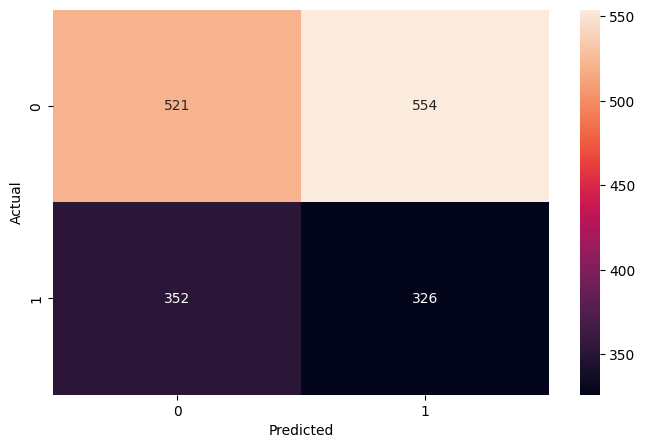

In [46]:
test_pred = np.random.randint(0,2,len(val_padded_seq))

# Printing the classification report
print(classification_report(val_labels, test_pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(val_labels, test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

A random classification would return a F1 score of 42%, precision of 37%, recall of 48%, and accuracy of 48%.

The deep learned model would return a F1 score of 85%, precision of 88%, recall of 81% and accuracy of 89%.